# Compare Two Extreme Models

AX/X

This notebook was written by Logan Qualls. Data for this work is sourced from the National Center for Atmospheric Research's Catchment Attributes and Meterology for Large-Sample Studies (CAMELS) dataset, and this notebook is designed to work specifically with Frederik Kratzert's NeuralHydrology (NH; https://github.com/neuralhydrology/neuralhydrology) and Grey Nearing's SACSMA-SNOW17 (SAC-SMA; https://github.com/Upstream-Tech/SACSMA-SNOW17). NH provides a flexible framework with a variety of tools specifically designed for straightforward application of Long Short-Term Memory networks to hydrological modeling. The SACSMA-SNOW17 model provides a Python interface for the SAC-SMA model.

At this point, we have created climate nonstationary experiments by 1) designing configuration files for NeuralHydrology and 2) SAC-SMA and 3) ensembled model runs and calculated performance metrics for each basins' extreme or random test years. Although notebook 4 provides a glimpse into the spatial distribution of a model's performance, it provides no insight into the benefits of varying model designs. This notebook allows us to to make quantifiable comparisons between models and experiments so we can assess, for example, the value of including dynamic climate index values, as opposed to static climate attributes, into the model.

As it stands, this notebook only performs analyses using models' NSE scores, but it is designed so that additional metric name/axes limit pairs can be added with minimal adjustment.

In [1]:
#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Import Libraries

In [2]:
#Import Python libraries
import os
import sys
import copy
import glob
import xarray
import logging
import numpy as np
from os import path
import pandas as pd
import pickle as pkl
from functions import * #load the million neuralhydrology functions I use here
from pathlib import Path
import statistics
from ruamel.yaml import YAML
from tqdm.notebook import tqdm
from scipy import stats, signal
import matplotlib.pyplot as plt
from pathlib import Path, PosixPath
from typing import Dict, List, Tuple, Union
from xarray.core.dataarray import DataArray

### Define Parameters

This is the only section you will need to edit code in.

For this notebook, you will need to specify **2** models that you would like to compare. Enter their information in the variables below. For example, if we are looking at comparing 1) a NeuralHydrology model that used dynamic climate indices and trained with NLDAS forcing data only on National Water Model (NWM) years against 2) a NeuralHydrology model that used static climate attributes and trained with NLDAS forcing data on NWM years, it would be set up as such:

In [3]:
#########################################################################################

#Define two model types to compare (xxx = [model1 attribute,model2 attribute])
models = ['nh','nh']
inputs = ['static','dynamic']
forcings = ['daymet','nldas_extended']
years = ['all','all']

index

#########################################################################################

##### Notebook Configurations

In [4]:
#########################################################################################

#Do we want plots to be inline or interactive?
interactive_plots = False

#########################################################################################

##### Paths

In [5]:
#########################################################################################

#Path to working_dir (current directory)
working_dir = Path(os.getcwd())

#Path to config directory (.../configs)
config_dir = working_dir / 'nh_lstm' / 'configs'

#Path to climate indices file (.../additional_features/{climate_file})
climate_indices_file = config_dir / 'additional_features/dyn_climate_indices_daymet_531basins_365lookback.p'

#########################################################################################

#If you use this repository's directory structure, you not need to edit the paths below, but just in case...

#Path to NH codebase (../neuralhydrology/neuralhydrology)
nh_dir = working_dir / 'neuralhydrology' / 'neuralhydrology'

#Path to main CAMELS directory (../camels)
camels_dir = working_dir / 'camels'

#Path to CAMELS forcing directory (../basin_dataset_public_v1p2)
camels_forcing_dir = camels_dir / 'basin_dataset_public_v1p2'

#Path to extreme dates directory (../train_test_splits)
dates_dir = working_dir / 'train_test_splits'

#Path to CAMELS attributes, version 2 file
camels_attributes_dir  = camels_dir / 'camels_attributes_v2.0/camels_attributes_v2.0.csv'

# Path to notebook_env_saves
env_saves_dir = working_dir / 'notebook_env_saves'

#########################################################################################

**You should not have to edit anything below this cell.**

The following cell orients the notebook to the settings defined above.

In [6]:
#########################################################################################

#Point to NeuralHydrology codebase
sys.path.append(str(nh_dir))

#Import NeuralHydrology functions
from functions import config
from functions.utils import load_basin_file

#########################################################################################

#Get current list of files in env_saves_dir
env_saves = os.listdir(env_saves_dir)

#########################################################################################

#Define index according to years used ('all' or 'nwm')
if years == 'nwm':
    
    #Index limited to years also avaliable for NWM
    index = pd.date_range('1995-10-01','2014-12-30')
    
if years == 'all':
    
    #All avaliable forcing years
    index = pd.date_range('1980-10-01','2014-12-30')

#########################################################################################

#Metrics to perform visual analyses on (add metrics, as desired)
plot_metrics = ['nse']
#Metrics' axes limits (add limits as you add metrics, as desired)
axes = [(0,1,0,1)]
    
#########################################################################################
        
#Make plots interactive or inline according to value of interactive_plots variable
if interactive_plots:
    %matplotlib notebook
    %matplotlib notebook
else:
    %matplotlib inline
    
#########################################################################################

### Sanity Check

In [7]:
#Double check there are the same amount of models, inputs, forcing, and years
assert len(models) == len(inputs) == len(forcings) == len(years)

### Load Source Data

Here we create a dictionary containing the basin metrics files we created in notebook 4/X. They are loaded in based on the variables defined above.

In [8]:
#Initiate dictionary to hold basin_metrics dictionarities (created in notebook 3)
metrics_dict = {}

#For every model, input, forcing, year pair...
for model,inp,forcing,year in zip(models,inputs,forcings,years):
          
    #Manually construct a name from model descriptors (assuming it already exists; sanity check)
    name = f'{model}_{inp}_extreme_{forcing}_{year}'

    #Manually construct a filename from model descriptors (assuming it already exists; sanity check)
    metrics_file = f'basin_metrics_{name}.pkl'

    #Open the basin_metrics file...
    with open(Path(env_saves_dir / metrics_file),'rb') as f:
        
        #Load it
        metric_data = pkl.load(f)
    
    #Save dictionary under model name
    metrics_dict[name] = metric_data

Now we use the loaded keys to define the model names, experiment types, metrics, and basins.

In [9]:
#Get model, experiment, metric, and basin information from metrics_dict
#Models
model_names = list(metrics_dict.keys())
#Experiments (list of experiments with matching names; necessary to compare)
experiments = [x for x in metrics_dict[model_names[0]].keys() if x in metrics_dict[model_names[1]].keys()]
#Metrics
metrics = list(metrics_dict[model_names[0]][experiments[0]])
#Basins
basins = list(metrics_dict[model_names[0]][experiments[0]][metrics[0]].index)

To be able to correlate model performance and attributes, we need to make sure the DataFrame indexes match. The attributes dataframe has an index of the integer versions of the CAMELS basins.

In [10]:
#Create a metrics_dict indexed by the integer version of the basin id
#For every model...
for model in model_names:
    
    #For every experiment...
    for experiment in experiments:
            
        #Create an index of basin ids as integers
        int_index = [int(x) for x in list(metrics_dict[model][experiment].index)]
            
        #Reindex camels ids as integers, not strings
        metrics_dict[model][experiment].index = int_index

Here we load in the attribtues file, drop columns that are not explicitly quantified, create a dictionary of DataFrames of the difference in metric scores between the two extreme models.

In [11]:
#Load CAMELS attributes file; gauge_id as index (integer form)
attributes = pd.read_csv(camels_attributes_dir, sep=';', index_col='gauge_id')

#Drop columns that are not quantitative values (could potentially be included if numerically categorized)
drop_cols = ['high_prec_timing','low_prec_timing','geol_1st_class',
             'geol_2nd_class','dom_land_cover','water_frac','organic_frac']

#Drop drop_cols
attributes = attributes.drop(drop_cols, axis=1)
#Get list of all basins from attributes
all_basins_int = list(attributes.index)
# Get list of basins in integer form
basins_int = list(metrics_dict[model][experiment].index)
#Drop any row that is not a CAMELs basin
attributes = attributes.loc[basins_int]

#Create dataframe to store metric differences (indexed by basin ids of type integer)
diff_dict = pd.DataFrame(index=basins_int)

#For every experiment...
for experiment in experiments:
    
    #Create a column for that experiment and fill the column with model1_metric - model2_metric values
    diff_dict[f'{experiment}'] = (metrics_dict[model_names[0]][experiment] -
                                  metrics_dict[model_names[1]][experiment])['nse']

#Join CAMELS attributes dataframe and difference dataframe together
attributes = attributes.join(diff_dict)
#Ensure all attribute values in sacem format for comparison
attributes = attributes.astype(np.float32)

#Take a peek at attributes dataframe
attributes.head()

p_mean  pet_mean  p_seasonality  frac_snow   aridity  \
gauge_id                                                           
1022500   3.608126  2.119256      -0.114530   0.245259  0.587356   
1031500   3.522957  2.071324       0.104091   0.291836  0.587950   
1047000   3.323146  2.090024       0.147776   0.280118  0.628929   
1052500   3.730858  2.096423       0.152097   0.352698  0.561914   
1054200   4.067132  2.128355       0.104960   0.299642  0.523306   

          high_prec_freq  high_prec_dur  low_prec_freq  low_prec_dur  \
gauge_id                                                               
1022500        20.549999       1.205279     233.649994      3.662226   
1031500        18.900000       1.148936     227.350006      3.473644   
1047000        20.100000       1.165217     235.899994      3.691706   
1052500        13.500000       1.129707     193.500000      2.896707   
1054200        17.500000       1.194539     220.300003      3.263704   

          glim_1st_class_frac  ...        q5        q95  high_q_freq  \
gauge_id                       ...                                     
1022500              0.590658  ...  0.204734   7.123049     3.900000   
1031500              0.448928  ...  0.111345   8.010503    18.900000   
1047000              0.308488  ...  0.196458   8.095148    14.950000   
1052500              0.497458  ...  0.305965   8.669019    14.100000   
1054200              0.871443  ...  0.256851  10.095605    16.049999   

          high_q_dur  low_q_freq  low_q_dur  zero_q_freq    hfd_mean  \
gauge_id                                                               
1022500     2.294118   65.150002  17.144737          0.0  166.250000   
1031500     3.286957   94.800003  14.697675          0.0  181.000000   
1047000     2.577586   71.550003  12.776786          0.0  184.800003   
1052500     2.517857   58.900002   7.316770          0.0  197.199997   
1054200     1.888235   82.199997   9.963636          0.0  183.449997   

          aridity_high  aridity_low  
gauge_id                             
1022500       0.043070     0.061813  
1031500      -0.014833     0.188904  
1047000      -0.001315     0.010338  
1052500       0.086346     0.057759  
1054200      -0.043031    -0.048504  

[5 rows x 52 columns]

### Analyses

##### Cumulative Density Function (CDF) Plots

Here we idenitify the similarities and differences between the extreme models we want to compare.

In [12]:
#Identify conflicting features
params1 = model_names[0].split('_')
params2 = model_names[1].split('_')
diff1 = ' '.join([x.capitalize() for x in params1 if x not in model_names[1]])
diff2 = ' '.join([x.capitalize() for x in params2 if x not in model_names[0]])
diffs = [diff1,diff2]

same = ' '.join([x.capitalize() for x in params1 if x in model_names[1]])

Here we plot the CDFs of a given metric for each model to compare regional predictive ability.

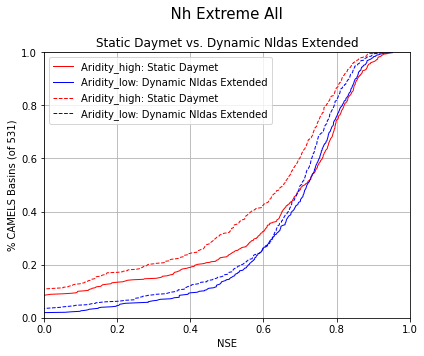

In [25]:
#Define different line styles to represent model 1 and model 2
ls = ['-','--']

#For every metric...
for metric,ax in zip(plot_metrics,axes):
    
    #Set figure size
    plt.figure(figsize=(6, 5))
    
    #For every model...
    for m,model in enumerate(model_names):
        
        #For every experiment...
        for i,experiment in enumerate(experiments):

            #Get list of basin metrics and sort according to value
            x = np.sort(metrics_dict[model][experiment][metric])
                
            #Create range of length x with consistent interval
            y = np.arange(len(x))/(float(len(x)))
            y = y.tolist()
            
            #Define default line values
            c = 'b'
            alpha = 1
            l = ls[m]
            lw = 1
                
            #If we are plotting aridity...
            if 'aridity'in experiment:
                
                #Plot red line
                c = 'r'
                
            #If we are plotting a "low" experiment...
            if 'low' in experiment:
                
                #Plot lighter color line
                c = 'b'

            #Plot line
            plt.plot(x, y, l,lw=lw,alpha=alpha,c=c,label=f'{experiment.capitalize()}: {diffs[i]}') #add label
            #Set axis limits according to metric
            plt.axis(ax)

    #Create super title detailing model similarities
    plt.suptitle(f'      {same}', fontsize=15)
    #Draw gridlines
    plt.grid()
    #Show legend
    plt.legend(loc=2)
    #Set x-label
    plt.xlabel(f'{metric.upper()}')
    #Set y-label
    plt.ylabel('% CAMELS Basins (of 531)')
    #Define title detailing model differences
    plt.title(f'{diff1} vs. {diff2}')

    #Show plot
    plt.tight_layout()

In [14]:
#If plots interactive, close manually
plt.close("all")

To see the percentage of basins that were helped or hurt by differing model designs, we can plot the difference in metrics between the two models as CDFs.

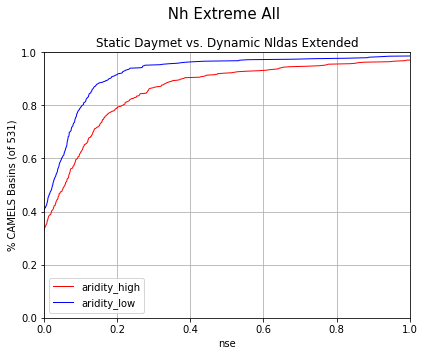

In [26]:
#For every metric...
for metric in plot_metrics:
    
    #Set plot size
    plt.figure(figsize=(6, 5))
    
    #For every experiment...
    for experiment in experiments:

        #Get the differences between model 1 and model 2 metrics and sort them
        x = np.sort((metrics_dict[model_names[0]][experiment] -
                     metrics_dict[model_names[1]][experiment])[metric])
        
        #Create a range of equal intervals
        y = np.arange(len(x))/(float(len(x)))
        y = y.tolist()
        
        #Define default line values
        c = 'b'
        alpha = 1
        l = '-'
        lw = 1

        #If we are plotting aridity...
        if 'aridity'in experiment:

            #Plot red line
            c = 'r'

        #If we are plotting a "low" experiment...
        if 'low' in experiment:

            #Plot lighter color line
            c = 'b'

        #Construct descriptive label
        label = f'{experiment}'
        
        #Plot line
        plt.plot(x, y, l,lw=lw,alpha=alpha,c=c,label=label)
        
    #Create super title detailing model similarities
    plt.suptitle(f'     {same}', fontsize=15)
    #Draw grid
    plt.grid()
    #Set axes according to metric
    plt.axis(ax)
    #Show legent
    plt.legend()
    #Set x-label
    plt.xlabel(f'{metric}')
    #Define title detailing model differences
    plt.title(f'{diff1} vs. {diff2}')
    #Set y-label
    plt.ylabel('% CAMELS Basins (of 531)')

    #Show plot
    plt.tight_layout()

In [16]:
#If plots interactive, close manually
plt.close("all")

##### Spatial Plots

At the end of notebook 3, we plotted a models' performance scores spatially to begin exploring correlations between model performance and basin location. Similarly, we can plot the differences of metrics spatially to visualize differences in models' performance for each basin. 

In [17]:
#Initiate lists of basin latitudes and longitudes
plot_lats = []
plot_lons = []

#For every basin...
for basin in basins:
    
    #Append lat/long from attribute columns to lists
    plot_lats.append(attributes.loc[int(basin),'gauge_lat'])
    plot_lons.append(attributes.loc[int(basin),'gauge_lon'])

#Make list arrays
plot_lats = np.array(plot_lats)
plot_lons = np.array(plot_lons)

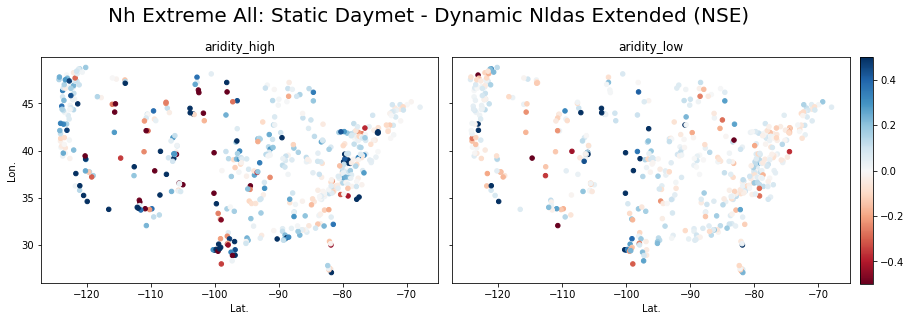

In [18]:
#For every metric and associated axes...
for metric,a in zip(plot_metrics,axes):

    #Create a 2x2 grid of plots (one plot for each experiment)
    fig, axs = plt.subplots(1,2,figsize = (12,4.5))

    #For every experiment...
    for e,experiment in enumerate(experiments):

        #Create throwaway list of metrics
        m_list = []

        #For every basin...
        for basin in basins_int:
            #Get metric data for a basin for that experiment
            m_data = diff_dict[experiment][basin]

            #Append that data to m_list
            m_list.append(m_data)

        #Plot scatter plot of basin locations and color based on their metric value
        im = axs[e].scatter(plot_lons, plot_lats,
            c=np.array(m_list),
            s=20,
            vmin=-0.5,vmax=0.5,
            cmap='RdBu')

        #Return the values (min, max) that are mapped to the colormap limits
        clims = im.get_clim()
        axs[e].set_title(f'{experiment}')
        fig.suptitle(f'{same}: {diff1} - {diff2} ({metric.upper()})', fontsize=20)

        #Define x and y labels
        for ax in axs.flat:
            ax.set(xlabel='Lat.', ylabel='Lon.')

    #Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()    

    #Add colorbar
    fig.subplots_adjust(right=0.9)
    cb_ax = fig.add_axes([1, 0.125, 0.015, 0.7])
    cbar = fig.colorbar(im, cax=cb_ax)
    
    #Plot
    plt.tight_layout()

In [19]:
#If plots interactive, close manually
plt.close("all")

While small variations in model performance can typically be attributed to statistical noise, a regional signal of improvement suggests something more. With the above comparative spatial plots as reference, plotting the CAMELS basins and coloring the points according to their physical characteristics may provide some insight on what kind of basins are improving with, for instance, the addition of dynamic climate indexes. Plotting this data spatially allows us to compare and contrast signals of improvement and signals of quantifiable basin attributes.

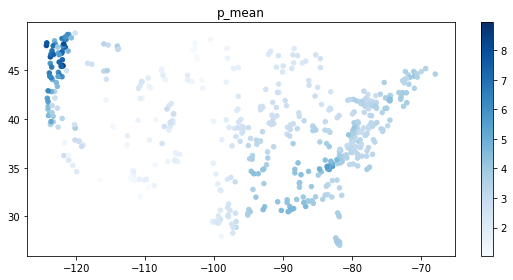

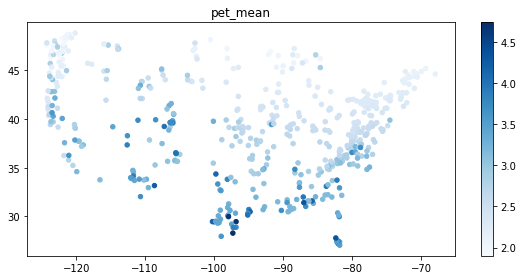

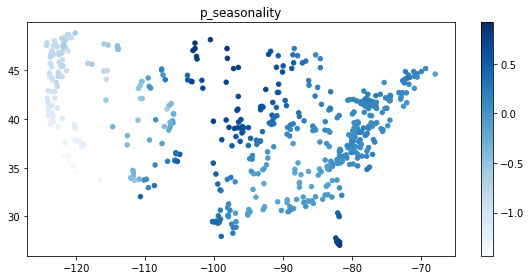

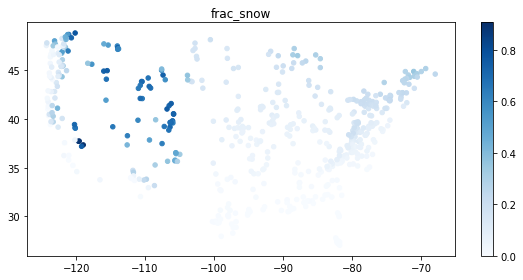

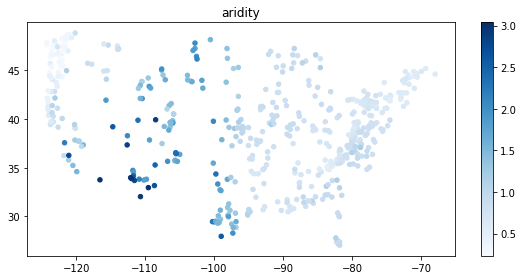

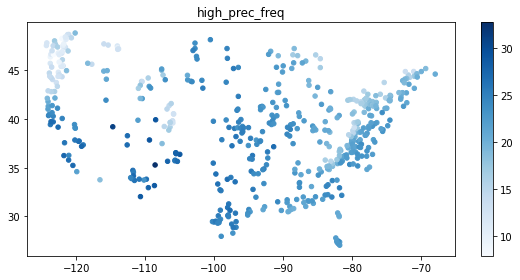

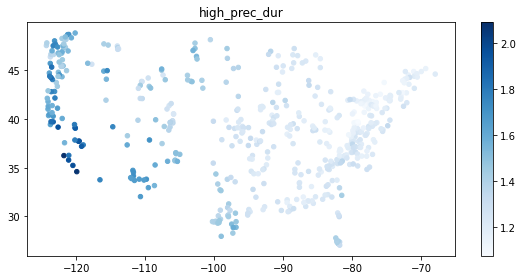

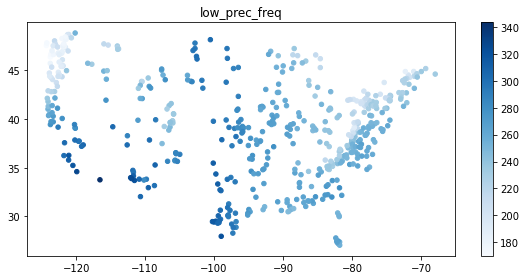

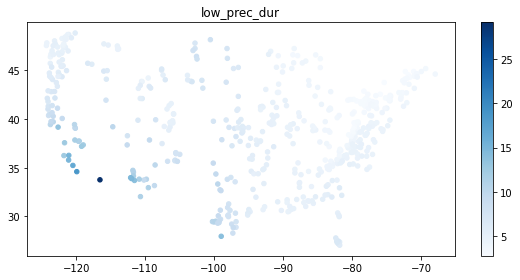

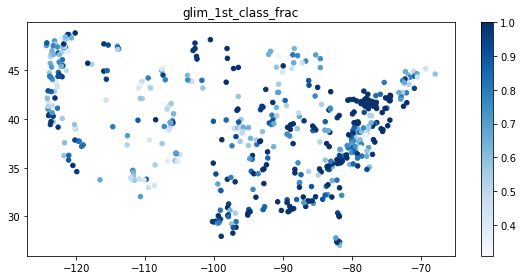

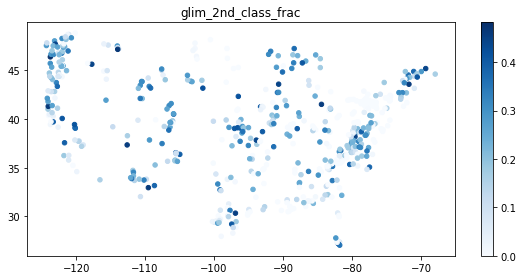

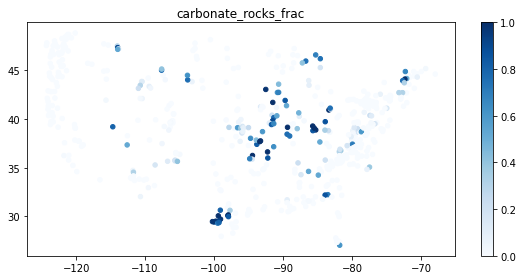

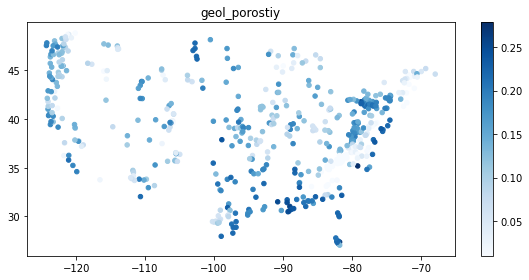

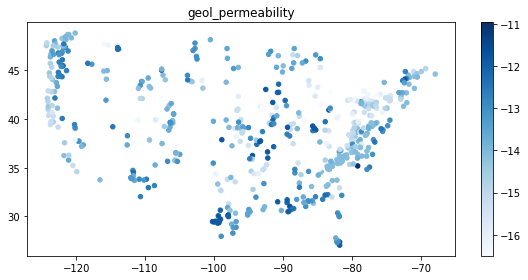

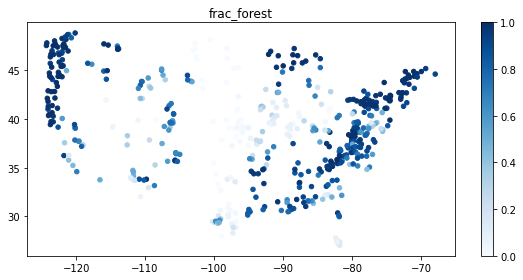

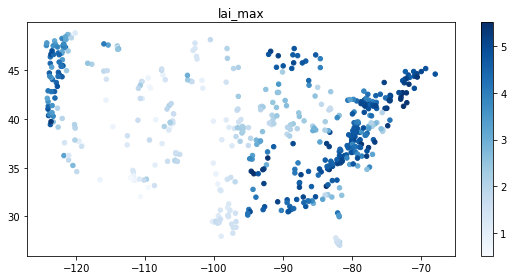

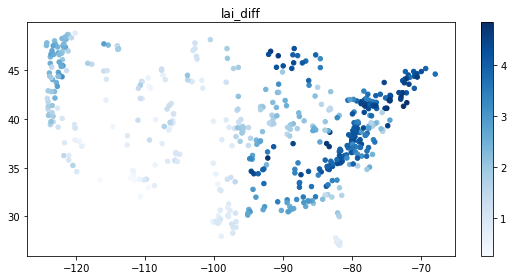

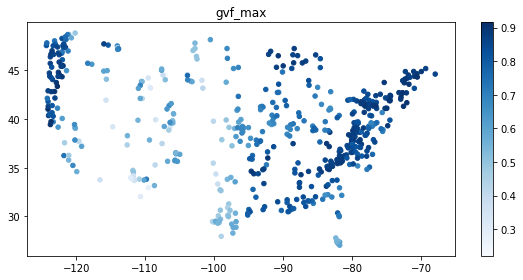

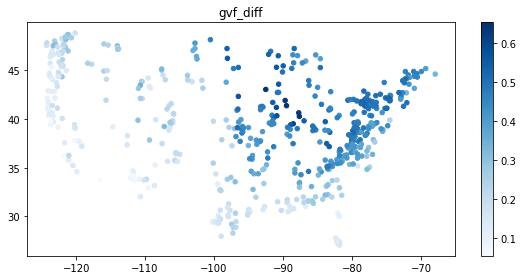

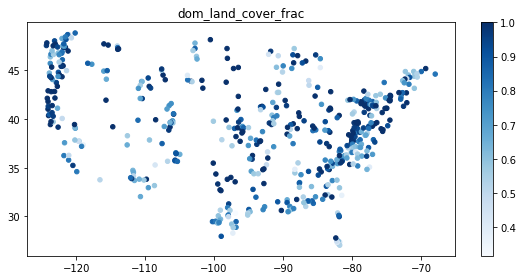

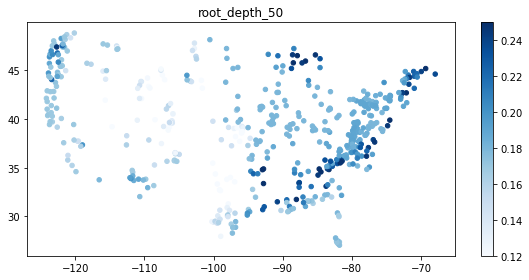

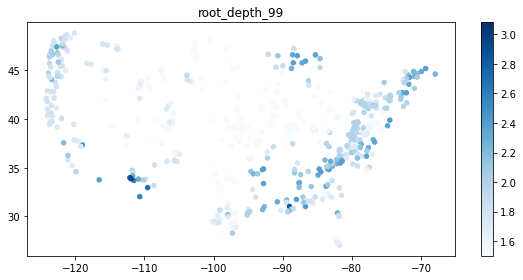

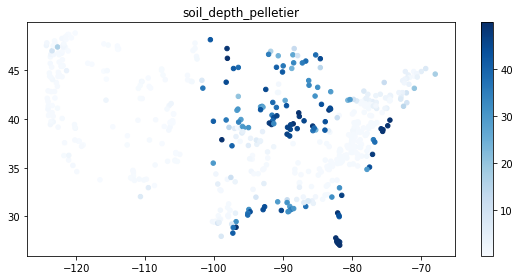

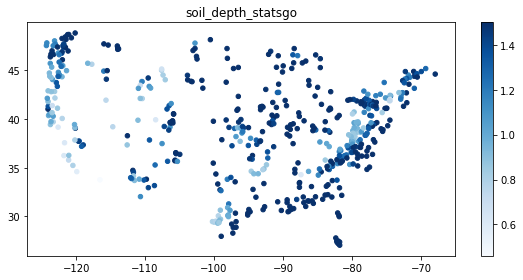

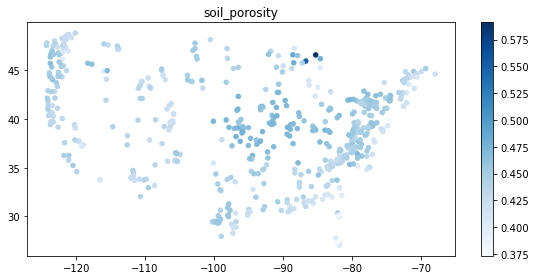

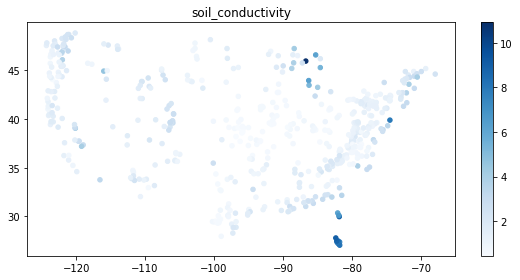

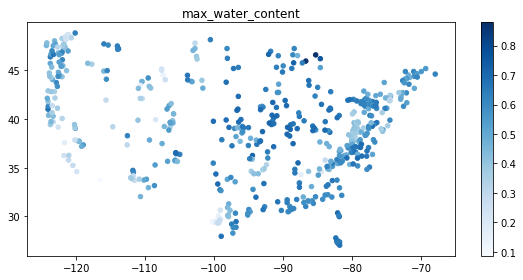

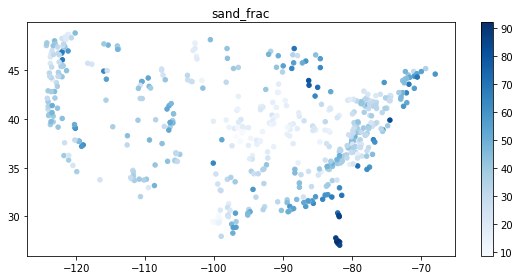

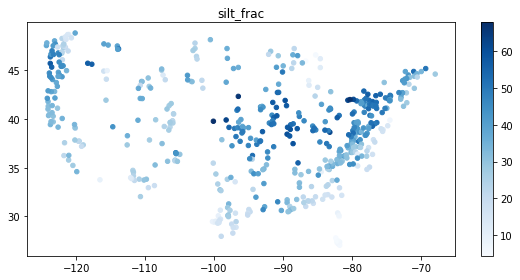

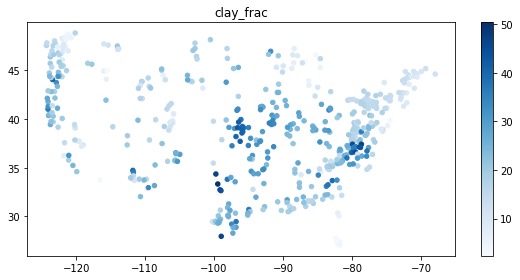

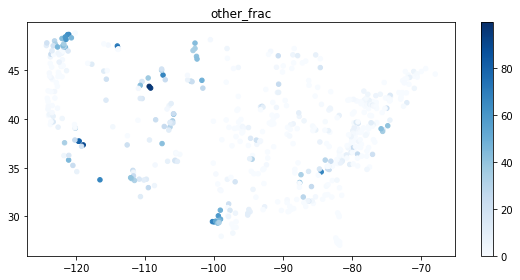

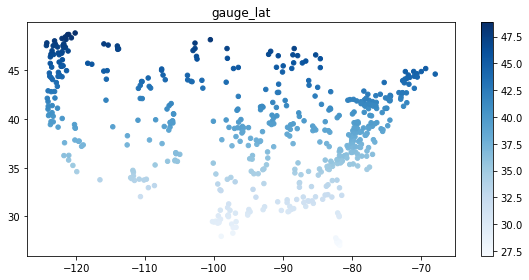

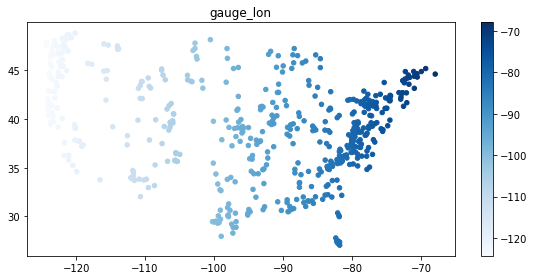

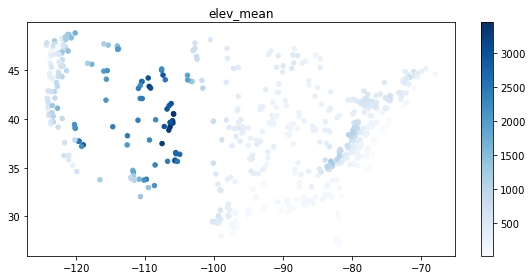

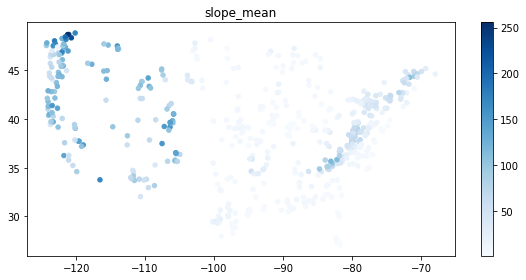

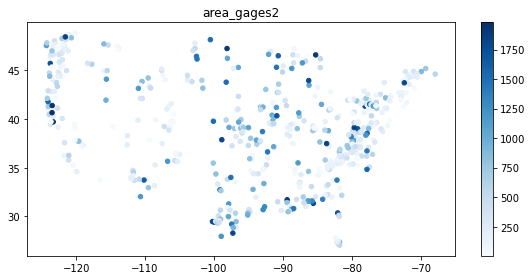

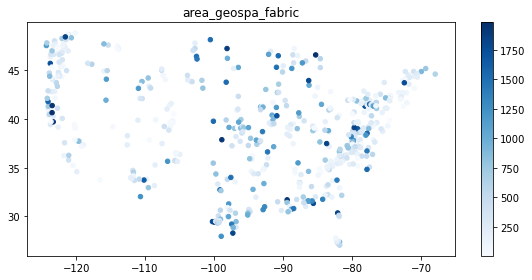

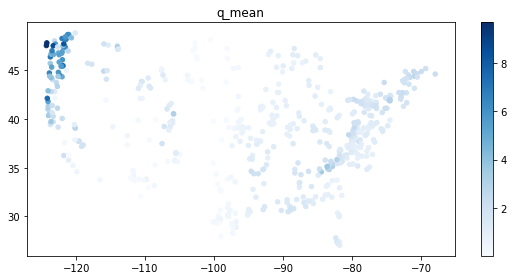

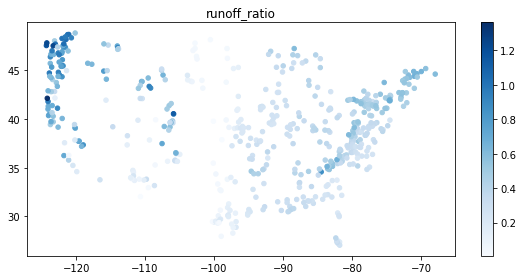

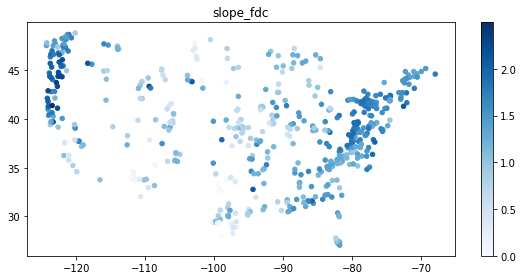

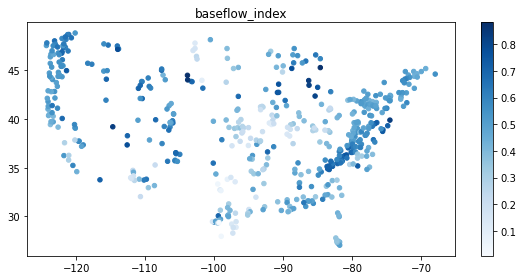

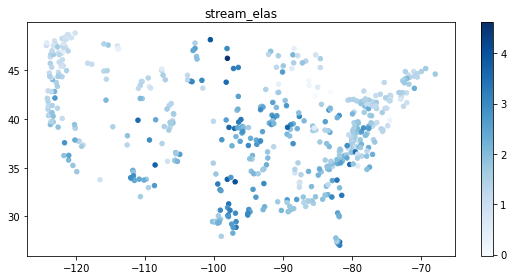

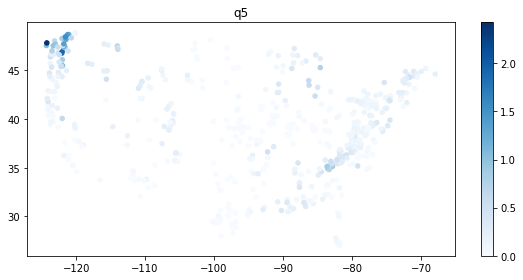

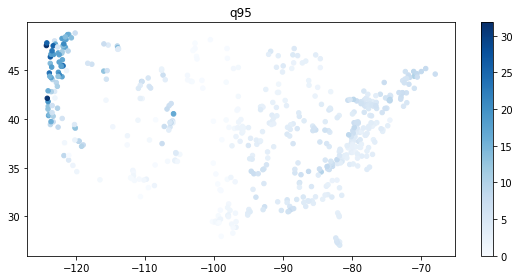

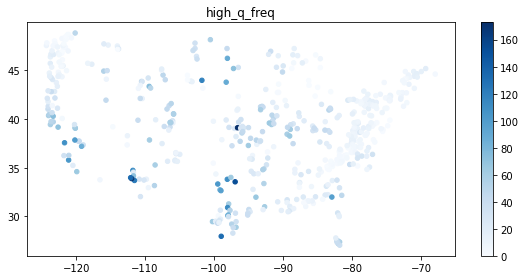

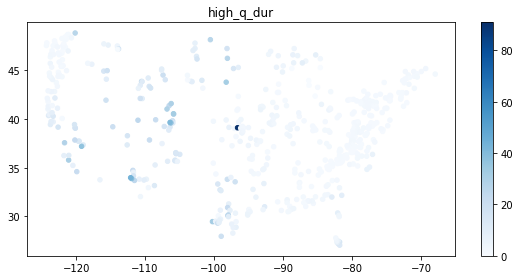

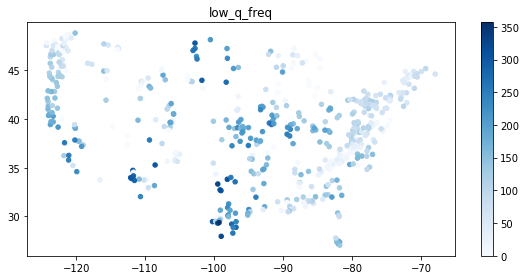

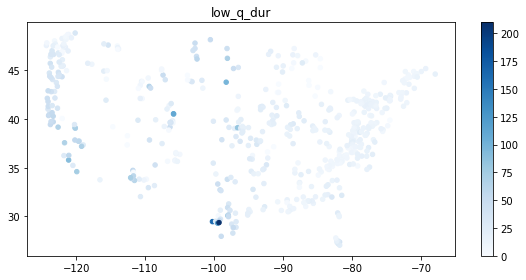

In [20]:
#Scale differences; blue is better, red is worse
for m, attribute in enumerate(list(attributes.columns[:-4])):
    fig, ax0 = plt.subplots(figsize=(8, 4))
    
    m_list = []

    for basin in basins:
        m_data = attributes[attribute][int(basin)]
        m_list.append(m_data)

    im = ax0.scatter(plot_lons, plot_lats,
        c=np.array(m_list),
        s=20,
#         vmin=-0.5,vmax=0.5,
        cmap='Blues')

    ax0.set_title(str(attribute))
    clims = im.get_clim()

    # colorbar
    fig.colorbar(im, orientation='vertical')

    #Plot
    plt.tight_layout()

In [21]:
plt.close("all")

While comparing visually provides some insight, let's relate what we have found: 1) difference in basin performance and 2) quantifiable attributes.

Here, we create plots for a defined metric. Each point on a given represents a basin. The basin's Y coordinate corresponds with its metric value in model 1 and the X coordinate corresponds with its metric value in model 2. The black line represents X = Y. Finally, each point (basin) is colored according to its static attribute

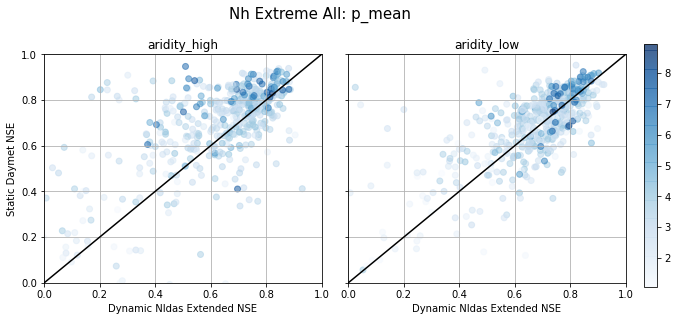

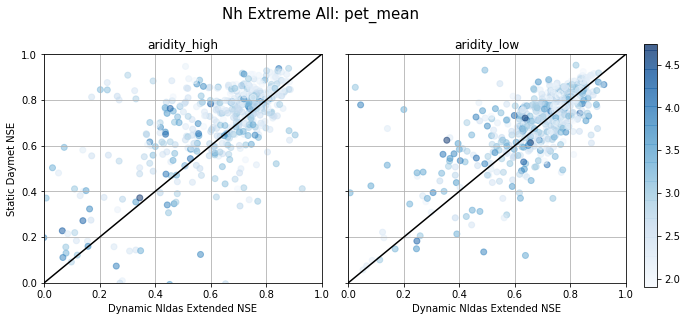

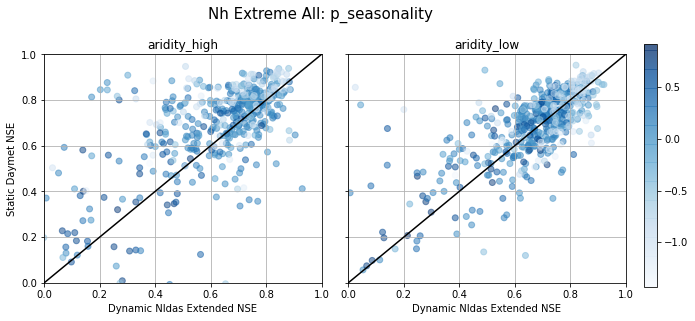

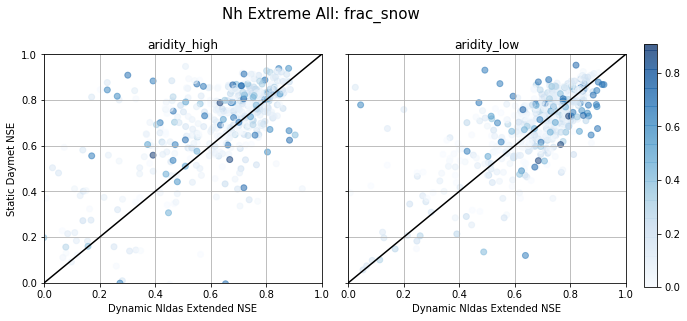

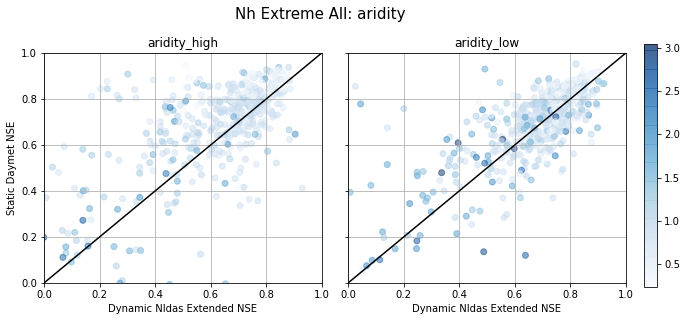

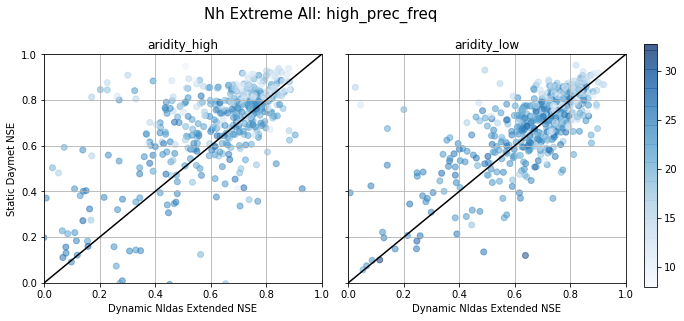

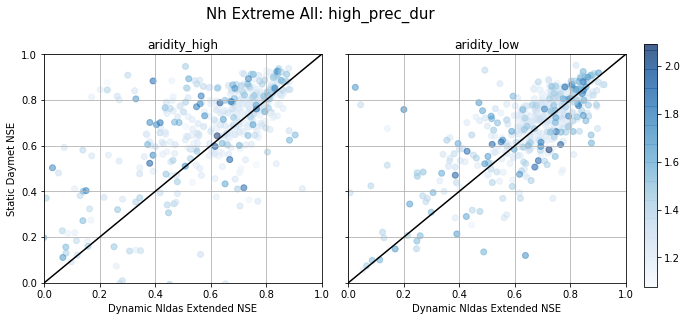

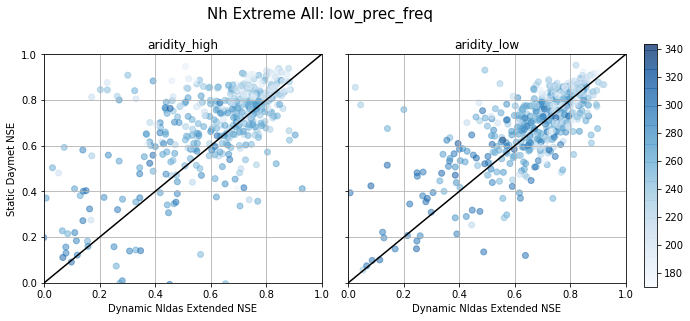

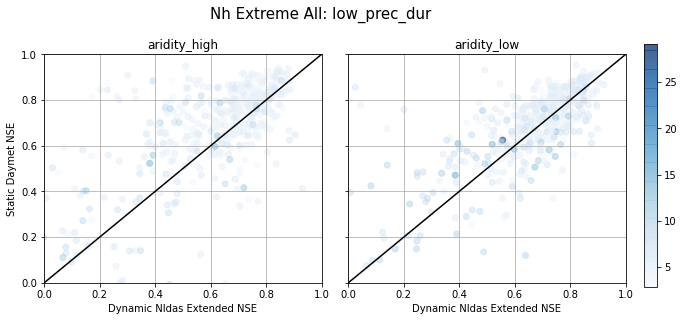

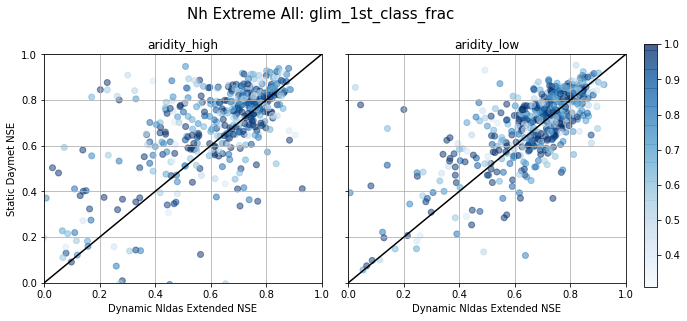

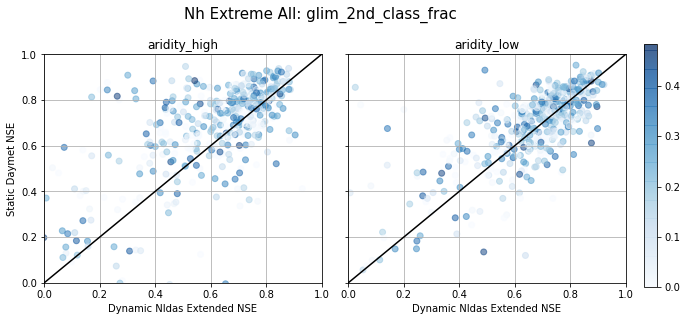

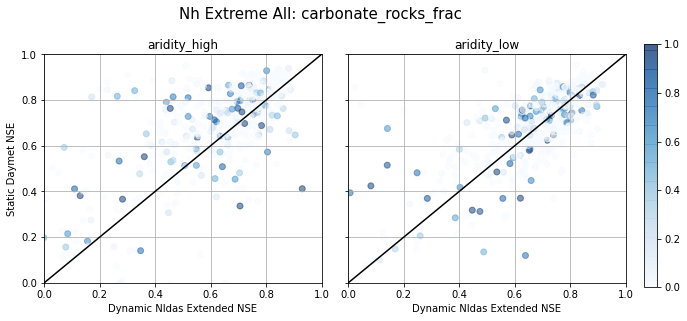

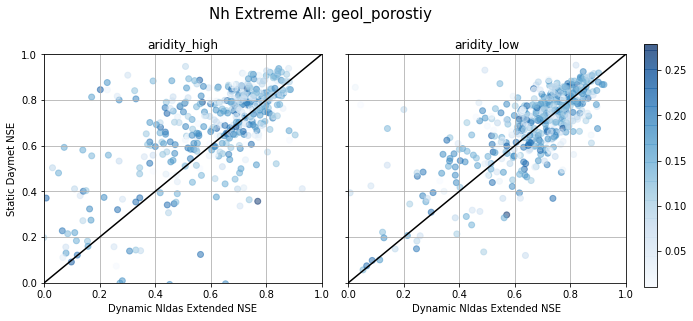

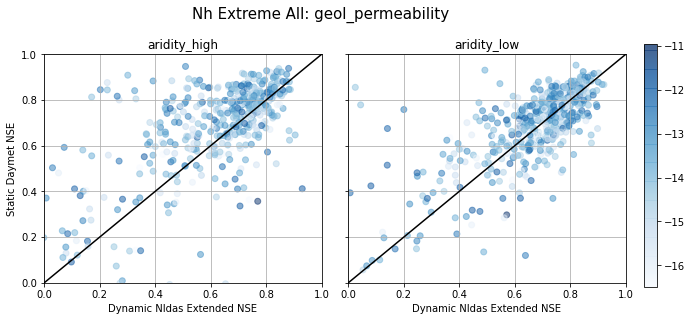

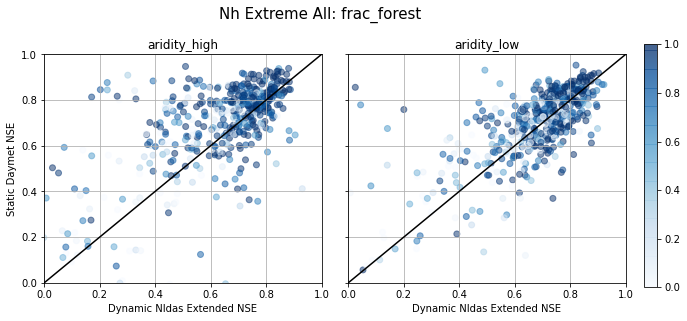

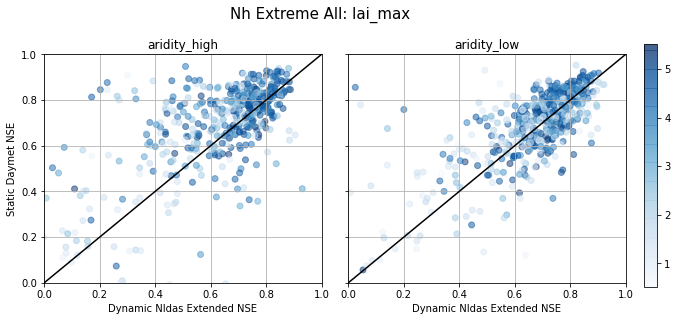

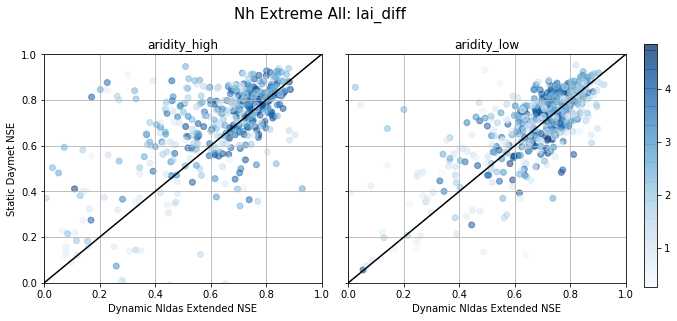

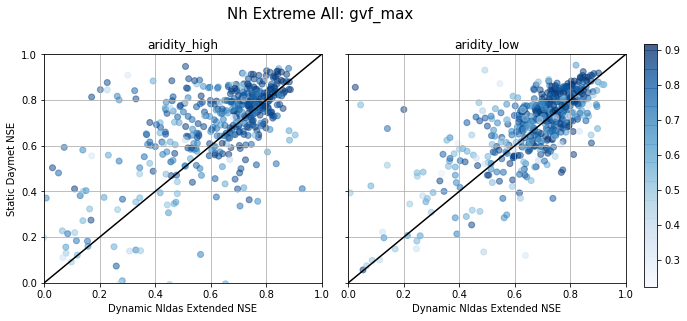

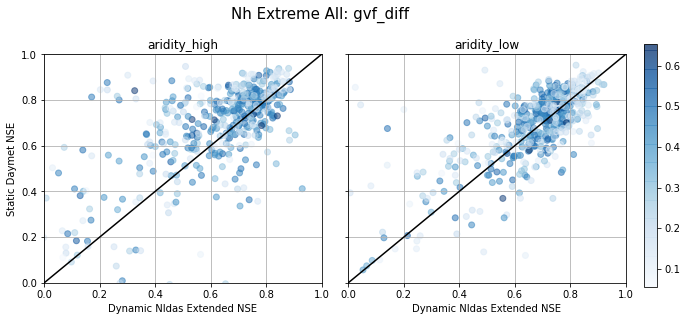

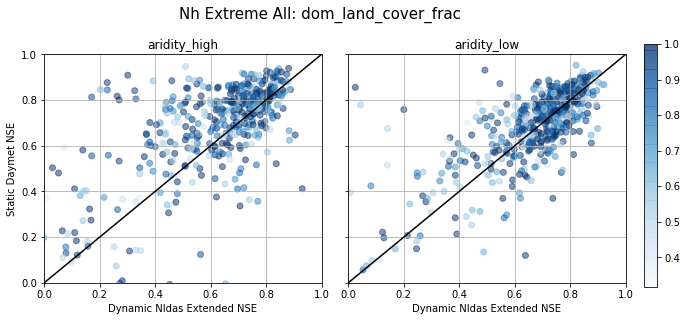

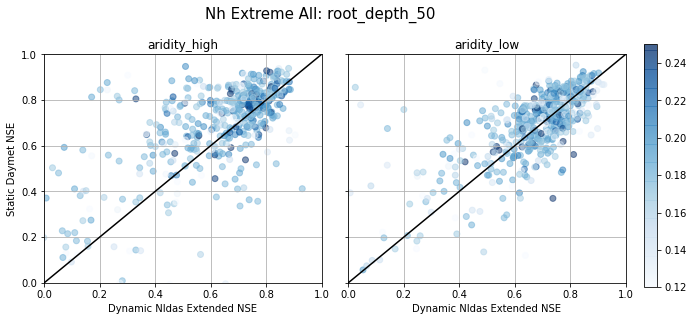

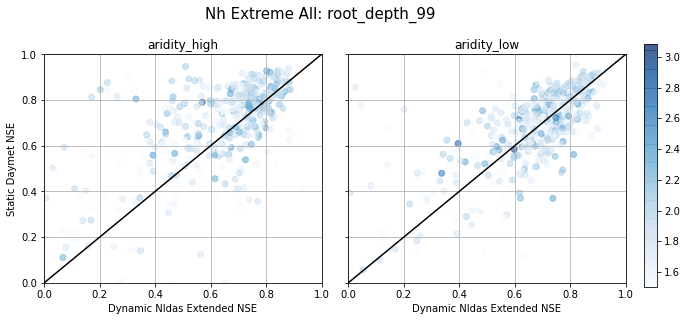

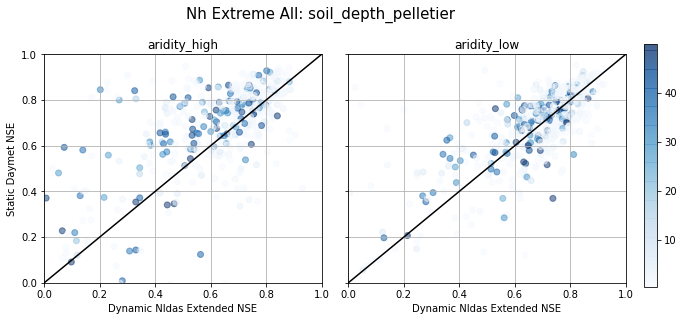

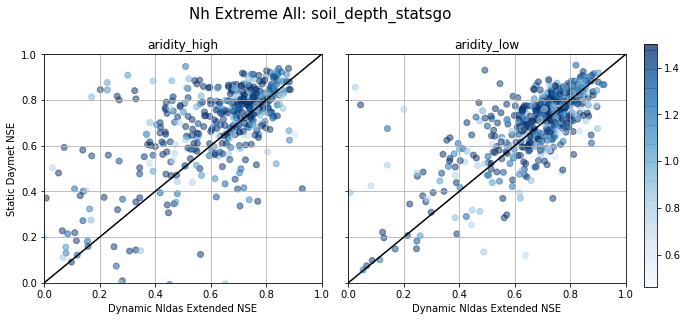

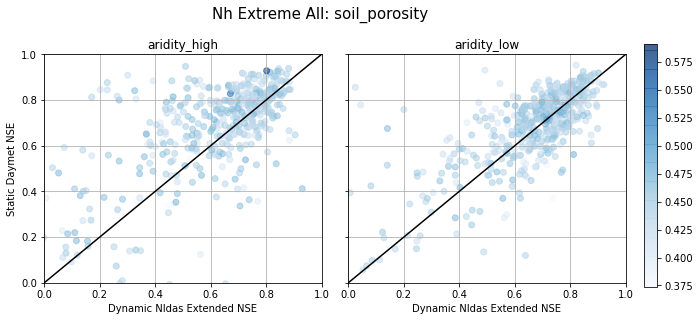

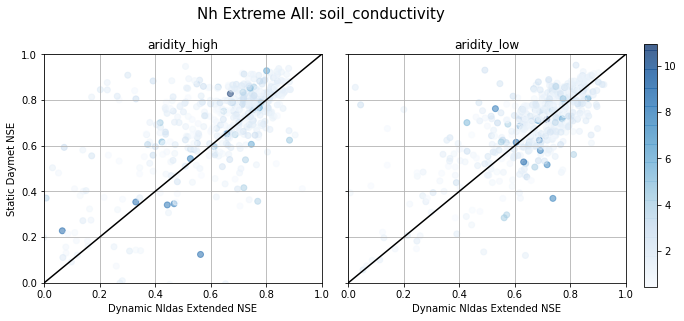

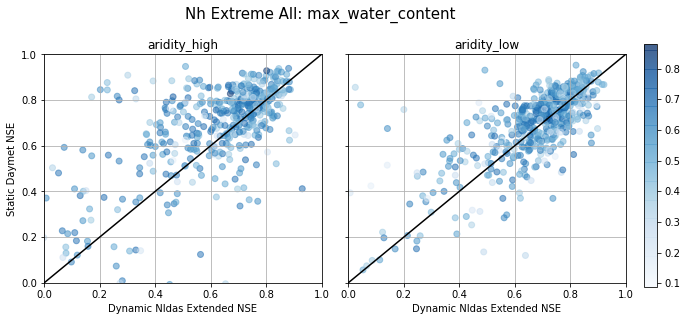

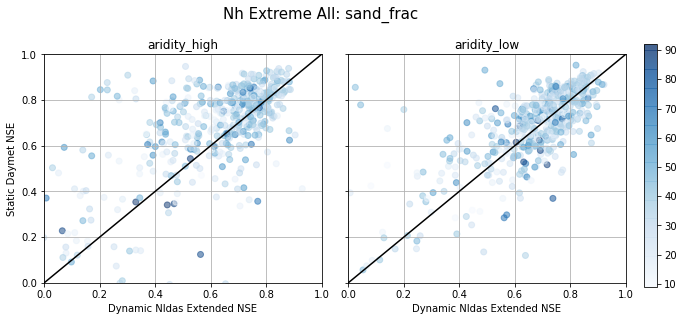

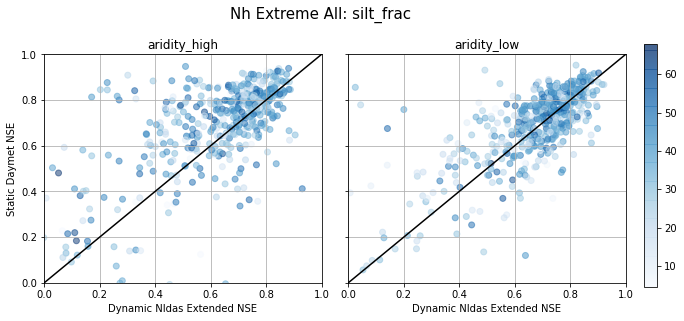

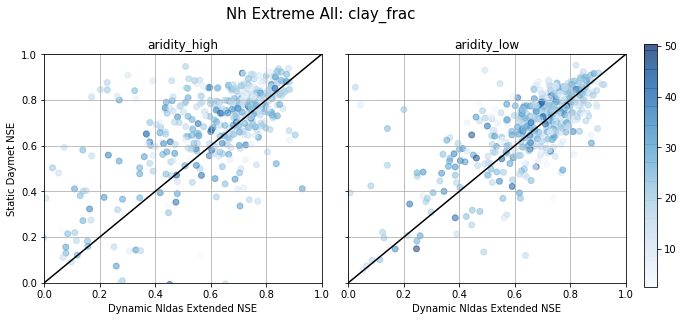

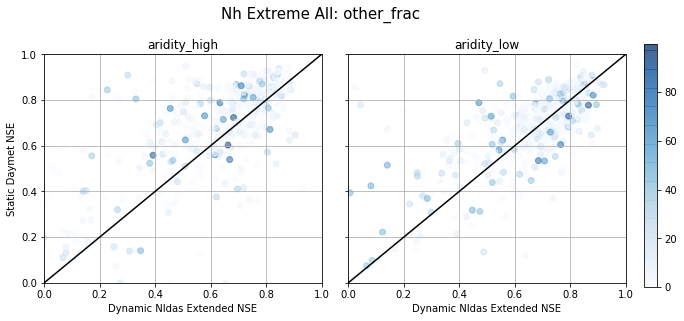

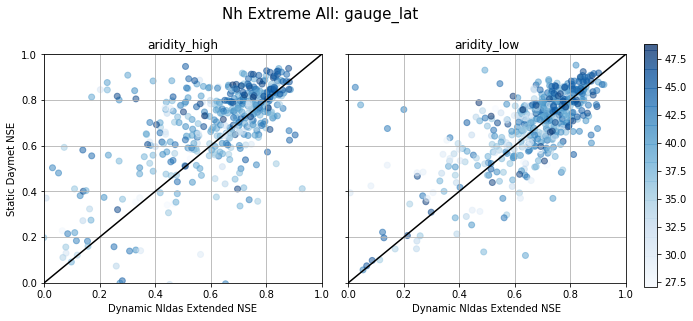

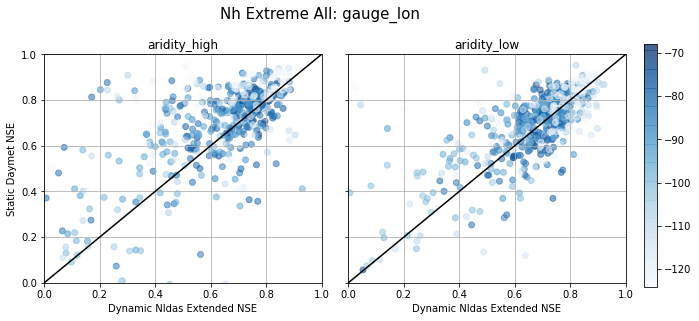

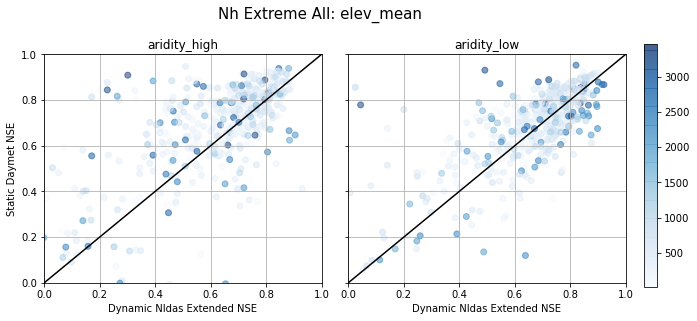

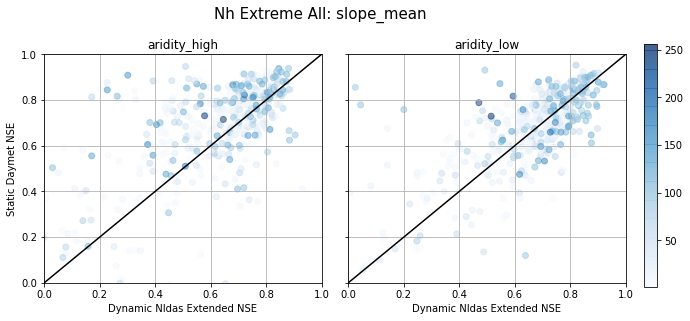

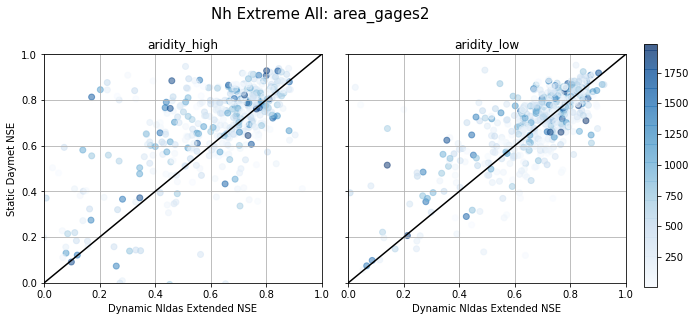

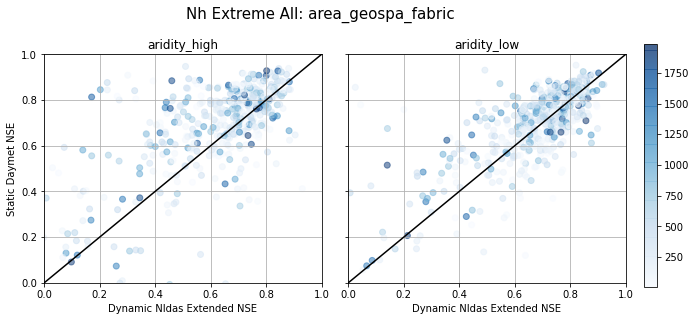

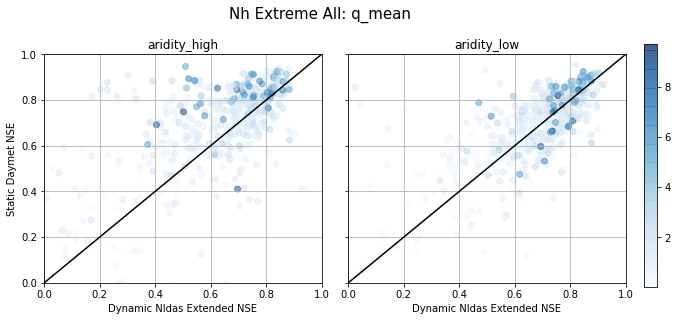

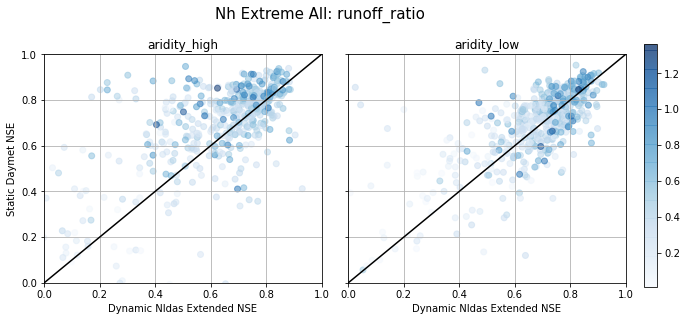

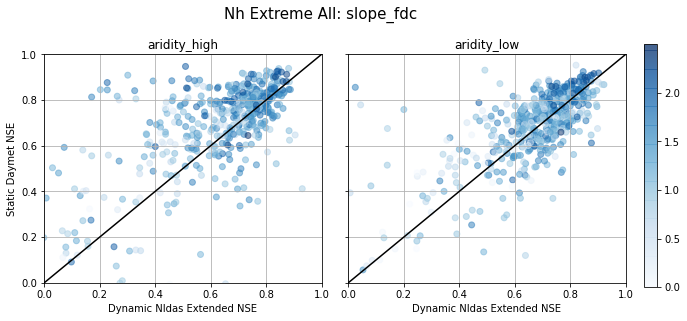

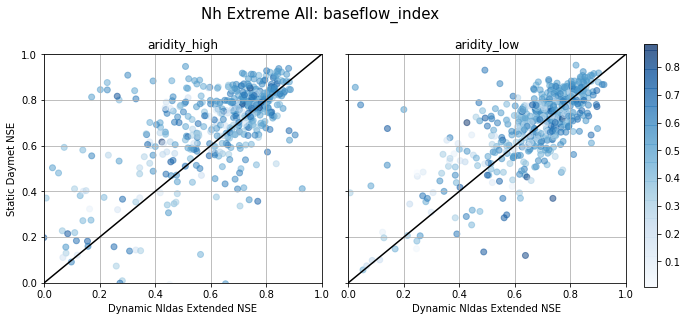

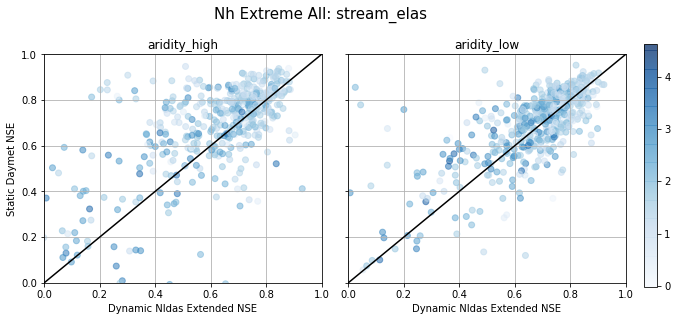

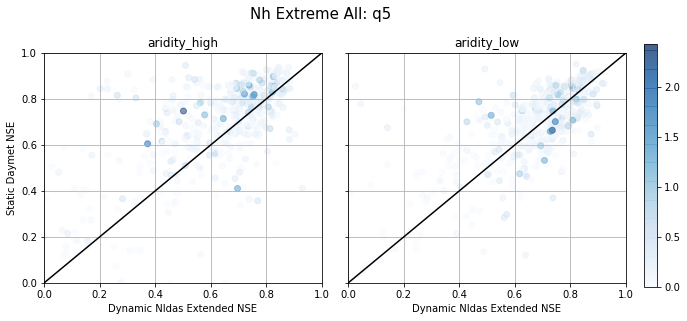

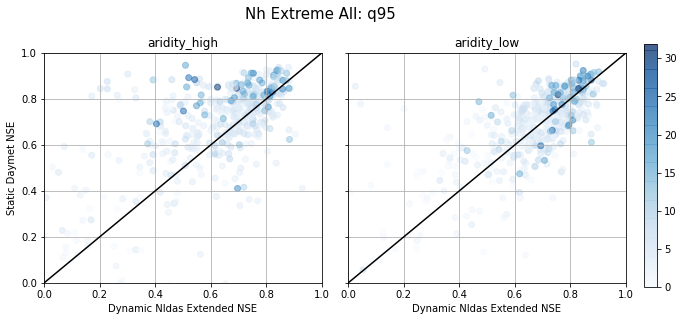

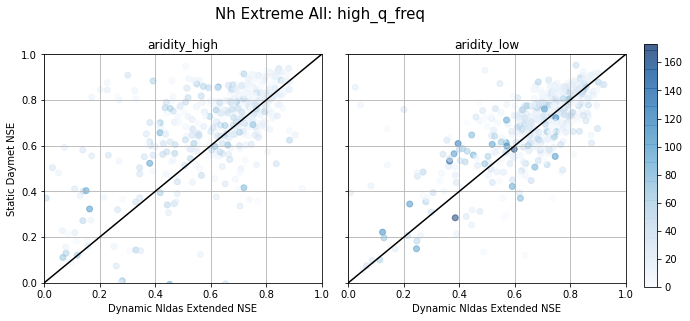

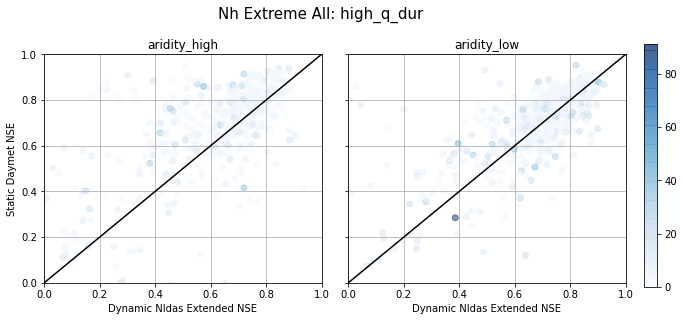

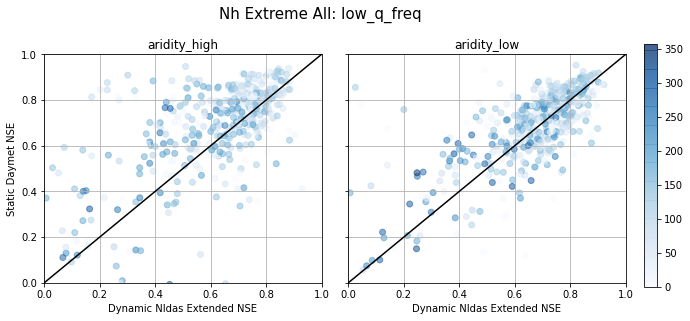

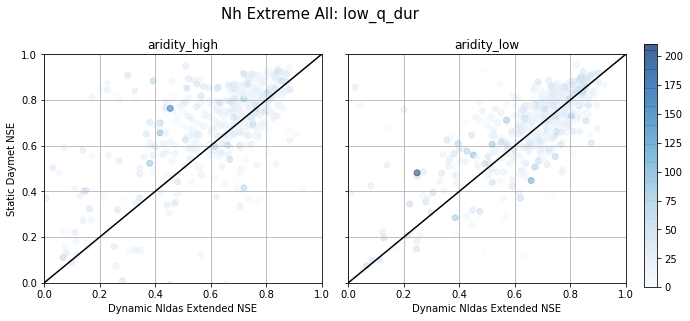

In [22]:
#For every metric and associated axes...
for metric,a in zip(plot_metrics,axes):
    
    #For every column (attribute) in the CAMELS attributes dataframe...
    for col in list(attributes.columns[:-4]):

        #Create a 2x2 grid of plots (one plot for each experiment)
        fig, axs = plt.subplots(1,2,figsize = (9,4.5))

        #And for every experiment...
        for e,experiment in enumerate(experiments):

            #Retrieve basin metrics for first model (y coordinate)
            y = pd.DataFrame(metrics_dict[model_names[0]][experiment][metric], 
                             index = basins_int).loc[attributes.index]
            #Retrieve basin metrics for second model (x coordinate)
            x = pd.DataFrame(metrics_dict[model_names[1]][experiment][metric], 
                             index = basins_int).loc[attributes.index]

            #Plot x = y line
            axs[e].plot([-1400,1],[-1400,1],c='k',label='y=x')
            
            #Plot X,Y (basin's metric scores for each model)
            im = axs[e].scatter(x, y,
                #Color by value of given static attribute
                c=attributes[col],
                #Make a little see-through
                alpha=0.5,
                #Set colormap (application of c)
                cmap='Blues')
            
            #Draw grid
            axs[e].grid()
            #Set axes according to metric being plotted
            axs[e].axis(a)
            #Set sub-titles (experiment)
            axs[e].set_title(f'{experiment}')
            
        #Set plot labels
        for ax in axs.flat:
            ax.set(xlabel=f'{diff2} {metric.upper()}', ylabel=f'{diff1} {metric.upper()}')
            
        #Set super title (attribute)
        fig.suptitle(f'{same}: {col}', fontsize=15)
        #Adjust position of subplots
        fig.subplots_adjust(right=0.85)
        #Format colorbar
        cbar_ax = fig.add_axes([1, 0.115, 0.02, 0.75])
        #Show colorbar
        fig.colorbar(im, cax=cbar_ax)

        #Hide inner axis labels
        for ax in axs.flat:
            ax.label_outer() 
            
        #Plot
        plt.tight_layout()

In [23]:
#If interactive, manually close all plots
plt.close("all")

##### Correlation Matrix Plot

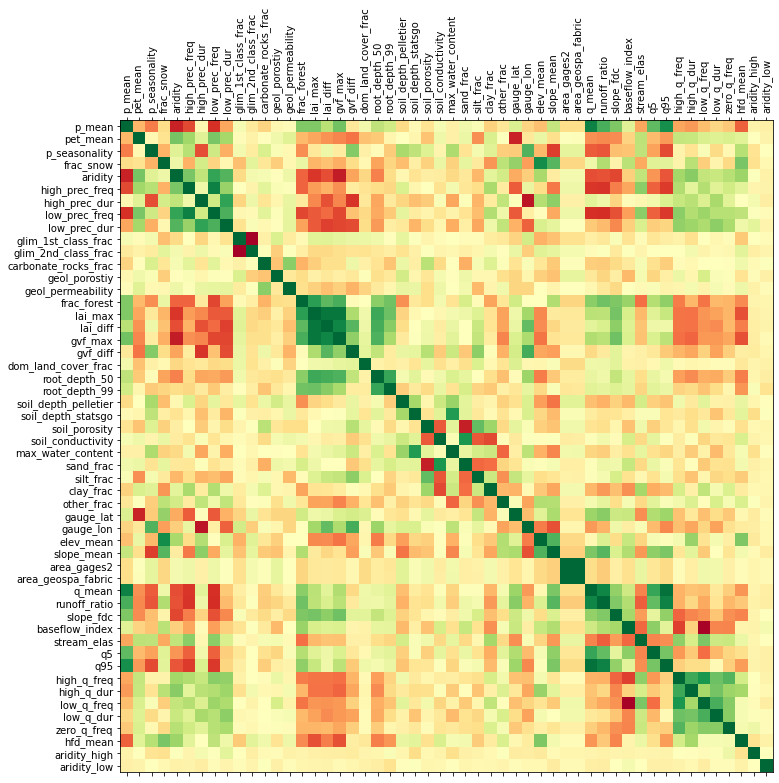

In [24]:
#Create correlation matrix of camels attributes/metric differences
attributes_corr = attributes.iloc[:,:].corr()
#Get labels for attributes
labels = [c for c in attributes_corr.columns]

#Create figure
fig = plt.figure(figsize=(12,12))
#Define axis
ax = fig.add_subplot(111)
#Display matrix and define colormap
ax.matshow(attributes_corr, cmap=plt.cm.RdYlGn)
#Show all xticks
ax.set_xticks(np.arange(len(labels)))
#Show all yticks
ax.set_yticks(np.arange(len(labels)))
#Use labels as xtick names
ax.set_xticklabels(labels)
#Use labels as ytick names
ax.set_yticklabels(labels)
#Rotate xtick labels 90 degrees for readability
plt.xticks(rotation=90)

#Show plot
plt.show()